# Homework: Sentiment analysis of product reviews (Part 1)


In this notebook you will explore logistic regression and feature engineering with scikit-learn functions. You will use product review data from Amazon to predict whether the sentiment about a product, inferred from its review, is positive ($+1$) or negative ($-1$). 

Even though more sophisticated approaches exist, such as tf-idf (discussed in module 1), for simplicity we'll use a bag-of-words representation as our feature matrix. If you need to review, feature extraction on text data was discussed in the first module of the course.

Your job is to do the following:
* Perform some basic feature engineering to deal with text data
* Use scikit-learn to create a vocabulary for a corpus of reviews
* Create a bag of words representation based on the vocabulary shared by the reviews
* Train a logistic regression model to predict the sentiment of product reviews.
* Inspect the weights (coefficients) of a trained logistic regression model.
* Make a prediction (both class and probability) of sentiment for a new product review.
* Given the computed weights, predictors and ground truth labels, write a function to compute the accuracy of the model.
* Inspect the coefficients of the logistic regression model and interpret their meanings.
* Compare multiple logistic regression models.

As usual, we import a few libraries we need. Later, you'll need to import more.

In [1]:
import pandas as pd
import numpy as np
import math
import string
import warnings
warnings.filterwarnings("ignore")
# use WIDER CANVAS:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Data preparation

We will use a dataset consisting of Amazon baby product reviews.

In [2]:
products = pd.read_csv('amazon_baby.gz')
print('We will work with',len(products),'reviews of baby products')

We will work with 183531 reviews of baby products


Let's take a peek at the data.

In [3]:
products.dropna(inplace = True)
products.reset_index(drop = True, inplace=True)
products

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3.0
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5.0
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5.0
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5.0
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5.0
...,...,...,...
182379,Baby Teething Necklace for Mom Pretty Donut Sh...,Such a great idea! very handy to have and look...,5.0
182380,Baby Teething Necklace for Mom Pretty Donut Sh...,This product rocks! It is a great blend of fu...,5.0
182381,Abstract 2 PK Baby / Toddler Training Cup (Pink),This item looks great and cool for my kids.......,5.0
182382,"Baby Food Freezer Tray - Bacteria Resistant, B...",I am extremely happy with this product. I have...,5.0


Let's examine the second review. In Pandas you can access entries by index number. Indices usually start at 0.

In [4]:
an_entry=1
for col in products.columns:
    print(f'{col.upper()}: {products.iloc[an_entry][col]}')

NAME: Planetwise Wipe Pouch
REVIEW: it came early and was not disappointed. i love planet wise bags and now my wipe holder. it keps my osocozy wipes moist and does not leak. highly recommend it.
RATING: 5.0


## Build word count vector for each review

First, we perform two simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Transform the reviews into a bag-of-words representation using a countvectorizer.

*Note*. For the sake of simplicity, we replace all punctuation symbols (e.g., !, &, :, etc.) by blanks. A better approach would preserve composite words such as "would've", "hasn't", etc. If interested, see [this page](https://www.nltk.org/_modules/nltk/tokenize/treebank.html)
for scripts with better ways of handling punctuation.

Make sure to look up the details for `maketrans`, a method of the `str` class. 

In [5]:
# These are the symbols we will replace
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


***Question 1.*** Complete a function `remove_punctuation(text)` to replace punctuation symbols by blanks in its `text` argument.

In [6]:
# YOUR CODE HERE
import string
import re
def remove_punctuation(text):
    text_ = text.translate(str.maketrans('', '', string.punctuation))
    return text_

Let's test your function on the sample review displayed earlier, but first, we create a clean corpus of reviews without punctuation.

In [7]:
print(products.shape)
review_no_punctuation = products['review'].apply(remove_punctuation)
print(review_no_punctuation[an_entry])

(182384, 3)
it came early and was not disappointed i love planet wise bags and now my wipe holder it keps my osocozy wipes moist and does not leak highly recommend it


## Create the feature matrix X
We need a feature matrix with one row for each review. Each row uses a bag-of-word representation on a vocabulary built on the entire corpus of reviews. This task can be easily carried out using the `CountVectorizer` class of sklearn. 

The vectorizer works by creating a vocabulary (set of words) in a corpus, tokenizing the words in the vocabulary (assigning a unique integer to each word), and creating a bag-of-words representation for each document (review) in the corpus. The integers assigned to the words in the vocabulary become positions in a feature vector that counts the number of occurrences of each particular word. Since in practice feature vectors are huge, a compressed row matrix (`csr_matrix`) is used for each row (see scipy's Compressed Sparse Row matrix for more information).

***Question 2.***
- Create an instance `cv` of the CountVectorizer class that can remove three types of words: *stop words* (listed below), words that appear in only one review, and words that appear in more than 60% of the reviews.
- Using the `fit` function, tokenize the words that were not removed from the clean corpus of reviews. As a side effect, this step creates a dictionary (`vocabulary_`) that maps words to integer positions.
- Create a bag-of-words csr_matrix (feature vector) for each review and store it in an additional column `word_count_vec` of the products dataframe.

Use the following list of stop words: ['you','he','she','they','an','the','and','or','in','on','at','is','was','were','am','are'].

In [8]:
# YOUR CODE HERE
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer

stopwords = ['you','he','she','they','an','the','and','or','in','on','at','is','was','were','am','are']
cv = CountVectorizer(stop_words = stopwords,
                    min_df=2, max_df=0.6)
cm = cv.fit_transform(review_no_punctuation)
products['word_count_vec'] = pd.Series([csr_matrix(i) for i in cm])

***Question 3.*** How big are the feature vectors? This, of course, is the same for all samples. What are the feature vector locations of the words 'great' and 'poor'? *Hint.* The vocabulary is a Python dictionary. 

In [9]:
# YOUR CODE HERE
print(products['word_count_vec'][an_entry].shape)
features = cv.get_feature_names_out()
features_li = features.tolist()
print(features_li.index('great'), features_li.index('poor'))

(1, 50336)
20113 33454


**Question 4.** Print the review of the 28th entry in `products` (remember 0-indexing!). Write code to answer the following questions:
- How many distinct words from the dictionary appear in the cleaned review? 
- How many times does the word 'book' appear in the review? 

In [10]:
# YOUR CODE HERE
print(products['review'][27])
print(len(products.iloc[27]['word_count_vec'].data))
print(products['review'][27].count("book"))

My son loves peek a boo at this age of 9 months so I thought this book would be perfect! This book doesn't engage him enough though it seems.  He does however like the cover the most if I make pretend blow-kisses and peekaboo gestures with the hands and show him. He also likes when I fan the hair towards his face.Maybe when he's older he will flip the flaps but right now he just likes the mirror at the end and the front cover. If I flip the book through he just takes the book and shakes it around.
55
4


## Extract sentiments

We will **ignore** all reviews with *rating = 3*, under the assumption that they usually express a neutral sentiment.

In [11]:
products = products[products['rating'] != 3]
print(f'We are left with {len(products)} reviews with strong sentiment')

We are left with 165679 reviews with strong sentiment


***Question 5.*** Consider reviews with a rating of 4 or higher to be *positive* reviews, and ones with rating of 2 or lower to be *negative*. Create a sentiment column, using $+1$ for the positive class label and $-1$ for the negative class label.

In [12]:
# YOUR CODE HERE
# YOUR CODE HERE
products['sentiment'] = products['rating'].apply(lambda x: -1.0 if x<3 else +1.0)
products  = products.dropna()
products

,name,review,rating,word_count_vec,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5.0,"(0, 49371)\t1\n (0, 28725)\t2\n (0, 29750)...",1.0
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5.0,"(0, 35845)\t1\n (0, 47772)\t1\n (0, 40354)...",1.0
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5.0,"(0, 28725)\t1\n (0, 29750)\t1\n (0, 49739)...",1.0
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5.0,"(0, 28725)\t1\n (0, 21029)\t1\n (0, 43894)...",1.0
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5.0,"(0, 21029)\t1\n (0, 2865)\t2\n (0, 8756)\t...",1.0
...,...,...,...,...,...
182379,Baby Teething Necklace for Mom Pretty Donut Sh...,Such a great idea! very handy to have and look...,5.0,"(0, 29750)\t1\n (0, 21029)\t1\n (0, 47772)...",1.0
182380,Baby Teething Necklace for Mom Pretty Donut Sh...,This product rocks! It is a great blend of fu...,5.0,"(0, 35098)\t1\n (0, 43775)\t1\n (0, 30188)...",1.0
182381,Abstract 2 PK Baby / Toddler Training Cup (Pink),This item looks great and cool for my kids.......,5.0,"(0, 28725)\t1\n (0, 35098)\t1\n (0, 20113)...",1.0
182382,"Baby Food Freezer Tray - Bacteria Resistant, B...",I am extremely happy with this product. I have...,5.0,"(0, 28725)\t3\n (0, 29750)\t1\n (0, 3931)\...",1.0


The dataset now contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

In [13]:
# Let's take a look at the new column
products[['name','rating','sentiment']]

,name,rating,sentiment
1,Planetwise Wipe Pouch,5.0,1.0
2,Annas Dream Full Quilt with 2 Shams,5.0,1.0
3,Stop Pacifier Sucking without tears with Thumb...,5.0,1.0
4,Stop Pacifier Sucking without tears with Thumb...,5.0,1.0
5,Stop Pacifier Sucking without tears with Thumb...,5.0,1.0
...,...,...,...
182379,Baby Teething Necklace for Mom Pretty Donut Sh...,5.0,1.0
182380,Baby Teething Necklace for Mom Pretty Donut Sh...,5.0,1.0
182381,Abstract 2 PK Baby / Toddler Training Cup (Pink),5.0,1.0
182382,"Baby Food Freezer Tray - Bacteria Resistant, B...",5.0,1.0


## Split data into training and test sets

Let's perform a 80-20 train/test split of the data. We'll use `random_state=0` so that everyone gets the same result.

In [14]:
len(products)

165679

In [15]:
train_data = products.sample(frac=.8, random_state=0)
test_data = products.drop(train_data.index)
print(f'We will use N={len(train_data)} training samples')
print(f'and {len(test_data)} testing samples')
print(f'Total samples: {len(products)}')

We will use N=132543 training samples
and 33136 testing samples
Total samples: 165679


## Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data. This model will use the column **word_count_vec** as a feature and the column **sentiment** as the target.

***Question 6.*** Create a logistic regression model called `sentiment_model` with scikit-learn (similar to the one in the class demo) with $L_2$-regularization and $C=100$ penalty. You will need to extract a feature matrix `X_train` and vector of true labels `y_train` from your training data.  To create the feature matrix X_train you will need to stack the rows of bag-of-words into a single matrix (you may want to check the function `vstack` in scipy).

*Note:* This may take a while on a big trainings set.

In [16]:
# YOUR CODE HERE
from sklearn.linear_model import LogisticRegression
from scipy.sparse import vstack
sentiment_model = LogisticRegression(penalty = 'l2', C = 100)
X_train = vstack(train_data['word_count_vec'])
y_train = train_data['sentiment']
sentiment_model.fit(X_train, y_train)
sentiment_model.coef_

array([[ 0.00622357,  0.02125912,  0.00385601, ..., -0.02988657,
         0.00499559,  0.00036633]])

X_train should now be a *compressed* feature matrix of size $N\times d$, where $d$ is the size of the vocabulary. Let's check it out.

In [17]:
print(type(X_train))
print(X_train.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(132543, 50336)


Now that we have fitted the model, we can extract the weights (coefficients) as a dictionary as follows:

***Question 7.*** Extract the weights of the words and store them in a dictionary `word_coef` that maps feature names (words) to coefficients. *Hint.* You can get the feature names using your vectorizer.

In [18]:
# YOUR CODE HERE
# Create an empty dictionary to store the word to coefficient mapping
words = list(cv.get_feature_names_out())
word_coef = {words[i] : sentiment_model.coef_.T[i] for i in range(len(words))}
word_coef

{'000': array([0.00622357]),
 '0001': array([0.02125912]),
 '001': array([0.00385601]),
 '01': array([0.21076174]),
 '012': array([0.61800147]),
 '02': array([-0.13877861]),
 '02090': array([0.25796433]),
 '02180': array([0.19853572]),
 '025': array([0.10545131]),
 '03': array([-0.8499318]),
 '03mo': array([-0.12868985]),
 '03months': array([-0.07652104]),
 '04': array([0.62649758]),
 '05': array([0.14662637]),
 '050': array([0.0046501]),
 '06': array([-0.23525849]),
 '06mths': array([0.049722]),
 '07': array([0.05275161]),
 '075': array([0.0632657]),
 '08': array([-0.09602406]),
 '09': array([-0.12934132]),
 '099': array([-0.34622282]),
 '0i': array([0.00261162]),
 '0star': array([-0.30941111]),
 '0z': array([0.01194751]),
 '10': array([-0.25945001]),
 '100': array([0.15194357]),
 '1000': array([-0.50961271]),
 '10000': array([-0.43034125]),
 '100000': array([0.11387693]),
 '1000x': array([-0.02036462]),
 '100150': array([0.01370192]),
 '1002': array([-0.01213798]),
 '100200': array([

There are thousands of coefficients in the model. Recall from the lecture that positive weights $w_j$ correspond to favorable reviews, while negative weights correspond to negative ones. 

Let's examime the coefficients of a few features as a sanity check. Did you get what you expected?

***Question 8.*** Find the coefficients of the following words: 'awesome', 'good', 'great', 'awful', 'terrible', 'poor'. How many words got a coefficient inconsistent with its meaning.

In [19]:
# YOUR CODE HERE
for j in ['awesome', 'good', 'great', 'awful', 'terrible', 'poor']:
    print(word_coef[j])

[1.89312482]
[0.59446098]
[1.59387189]
[-1.37238017]
[-2.37636794]
[-2.94376333]


***Question 9.*** Fill in the following block of code to compute the number `num_pos_weights` of positive (>0) weights and the number `num_neg_weights` of negative (<=0) weights. Print both counts and verify that they add to the total number of coefficients you computed earlier in the notebook.

In [20]:
# YOUR CODE HERE
pos = 0
neg = 0
for n in word_coef.values():
    if n <= 0:
        neg+=1
    else:
        pos+=1
print(pos, neg)
print(pos + neg == len(sentiment_model.coef_[0]))

32098 18238
True


## Making predictions with logistic regression

Now that a model is trained, we can make predictions on the **test data**. In this section, we will explore this in the context of 8 examples in the test dataset.  We refer to this set of examples as the **sample_test_data**.

In [21]:
sample_test_data = test_data.iloc[90:98]
sample_test_data

,name,review,rating,word_count_vec,sentiment
536,Baby Trend Diaper Champ,I chose this pail because I didn't want to spe...,1.0,"(0, 29750)\t1\n (0, 49739)\t1\n (0, 20562)...",-1.0
538,Baby Trend Diaper Champ,This odor absorbing champ even absorbs the odo...,5.0,"(0, 28725)\t1\n (0, 6378)\t1\n (0, 43775)\...",1.0
541,Baby Trend Diaper Champ,I think this should be a staple in every house...,5.0,"(0, 47273)\t2\n (0, 21029)\t2\n (0, 6378)\...",1.0
544,Baby Trend Diaper Champ,I love this product. You can use any regular t...,5.0,"(0, 8527)\t1\n (0, 47273)\t2\n (0, 21029)\...",1.0
546,Baby Trend Diaper Champ,This is one of the best things that we got as ...,5.0,"(0, 49371)\t1\n (0, 8527)\t2\n (0, 24449)\...",1.0
557,Baby Trend Diaper Champ,I've worked with kids more than half my life. ...,5.0,"(0, 8527)\t1\n (0, 28725)\t5\n (0, 20562)\...",1.0
566,Baby Trend Diaper Champ,I had tried a Diaper Genie at a friend's house...,5.0,"(0, 8527)\t1\n (0, 29750)\t3\n (0, 20562)\...",1.0
569,Baby Trend Diaper Champ,We did alot of research on diaper pails before...,2.0,"(0, 44126)\t1\n (0, 8527)\t1\n (0, 49739)\...",-1.0


Let's dig deeper into the rows of the **sample_test_data**. Here are the ratings and reviews.

In [22]:
for i in range(len(sample_test_data)):
    print('\nrating:',sample_test_data.iloc[i]['rating'])
    print('review:\n',sample_test_data.iloc[i]['review'])


rating: 1.0
review:
 I chose this pail because I didn't want to spend alot on a daiper pail.  In the end, I spent more because I had to buy a different one.  After only a few months of using it, the seal broke and  the odor came through.  The latch would get stuck making it difficult to change the bag.  This is certainly not worth buying!!

rating: 5.0
review:
 This odor absorbing champ even absorbs the odors from those diaper genies down the street...  My one step diaper champ sure beats the 5 steps it takes to twist a diaper in the that genie.  Who want to do extra when you are doing enough as it is? - The CHAMP is icing on the cake - every mommy gets psyched when their boy (or girl) poops because it means everything is working... and when you toss that diaper into the the mini R2D2 unit, you know you did it right... simplicity... ahh...

rating: 5.0
review:
 I think this should be a staple in every household with a child!  It is so much easier to use than the diaper genie and the o

We will now make a **class** prediction for our **sample_test_data**. We hope that `sentiment_model` predicts **+1** if the true sentiment is positive and **-1** if the true sentiment is negative. Recall from lecture that the score $z$ for the logistic regression model  is defined as:
$$z_i = \mathbf{w}\cdot \mathbf{x}_i$$ 

where $\mathbf{x}_i$ represents the features (word counts) for sample $i$ and the corresponding score is a number in the range $(-\infty,\infty)$. We will write some code to obtain the **scores** using sklearn.

***Question 10.*** Using your model's `decision_function`, compute the **scores** (these are the $z$-values) of the reviews in `sample_test_data` and print the true sentiment. How many scores are compatible with the true sentiment values? Interpret your findings.

In [23]:
# YOUR CODE HERE
scores = []
scores = sentiment_model.decision_function(vstack(sample_test_data['word_count_vec'].values))
print(scores, len(scores))

[-6.37542416  9.8184719   5.79098655  9.32393057 13.73935754 18.79244663
 -6.62110622 14.91074609] 8


### Predicting sentiment

These scores can now be used to make class predictions, as follows:

$$
\hat{y} = 
\left\{
\begin{array}{ll}
      +1 & \mathbf{w} \cdot \mathbf{x}_i > 0 \\
      -1 & \mathbf{w}\cdot \mathbf{x}_i \leq 0 \\
\end{array} 
\right.
$$

***Question 11.*** Using scores, write python code to compute and print $\hat{y}$, the class predictions:

In [24]:
# YOUR CODE HERE
print([np.sign(x) for x in scores])

[-1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0]


*Sanity check*. Run the following code to check whether the class predictions obtained using your code are the same as those produced by sklearn.

In [25]:
print("Class predictions according to sklearn:")
print(sentiment_model.predict(vstack(sample_test_data['word_count_vec'].values)))

Class predictions according to sklearn:
[-1.  1.  1.  1.  1.  1. -1.  1.]


### Probability predictions

Recall from the lectures that we can also calculate the probabilities that $y=+1$ from the scores using:
$$
\mbox{Pr}(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1+e^{-\mathbf{w}\cdot\mathbf{x}_i}}
$$

***Question 12.*** Using the variable `scores` computed previously, write a single line of code to estimate the probability that a sentiment is positive using the above formula. Print the results. For each row, the probabilities should be a number in $[0, 1]$. Of the eight data points in **sample_test_data**, which one, classified as positive, has the *lowest probability* of being classified as a positive review? Was this prediction correct?

In [26]:
# YOUR CODE HERE
prob = 1/(1+np.exp(-scores))
prob

array([0.0017    , 0.99994557, 0.99695434, 0.99991075, 0.99999892,
       0.99999999, 0.00133018, 0.99999967])

***Question 13.*** Now compute estimated probabilities with sklearn by using the function `predict_proba` on your model.

*Sanity check*: Make sure your probability predictions match the ones obtained from sklearn.

In [27]:
# YOUR CODE HERE
sentiment_model.predict_proba(vstack(sample_test_data['word_count_vec'].values))

array([[9.98299998e-01, 1.70000241e-03],
       [5.44337421e-05, 9.99945566e-01],
       [3.04566240e-03, 9.96954338e-01],
       [8.92544013e-05, 9.99910746e-01],
       [1.07912652e-06, 9.99998921e-01],
       [6.89515645e-09, 9.99999993e-01],
       [9.98669815e-01, 1.33018494e-03],
       [3.34460711e-07, 9.99999666e-01]])

### Find the most positive and most negative reviews

We now turn to examining the test dataset, **test_data** and, for faster performance, use sklearn to form predictions on all of the test data points.

***Question 14.*** Using the `sentiment_model`, find the 20 reviews in the entire **test_data** with the **highest probability** of being classified as a **positive review**. We refer to these as the "most positive reviews." Recall that you can make probability predictions by using `.predict_proba` and you can select the $n$ largest values of a frame with the function `nlargest`.

In [28]:
# YOUR CODE HERE
prob = pd.Series(sentiment_model.predict_proba(vstack(test_data['word_count_vec'].values))[:,1])
prob.nlargest(20)

1107     1.0
1307     1.0
1500     1.0
1552     1.0
4130     1.0
4229     1.0
5031     1.0
5086     1.0
7356     1.0
7562     1.0
7650     1.0
7765     1.0
8792     1.0
9156     1.0
9234     1.0
9432     1.0
10577    1.0
12439    1.0
13328    1.0
13543    1.0
dtype: float64

***Question 15.***
Now, repeat this exercise to find the 20 "most negative reviews" in the test data. Recall that a review is considered negative if it has a low probability of being positive.

In [29]:
# YOUR CODE HERE
prob.nsmallest(20)

1820     8.963892e-23
1860     1.381324e-19
400      3.206315e-19
30818    2.515375e-17
25401    9.641074e-17
24471    2.004400e-16
25878    5.380100e-15
7021     8.323988e-15
20679    2.272732e-14
20109    3.786863e-14
26306    1.596488e-13
10776    1.711252e-13
17201    1.883241e-13
2415     2.173204e-13
12251    4.578693e-13
15196    5.159440e-13
2272     1.090649e-12
31313    2.364168e-12
30546    3.467713e-12
10872    3.563562e-12
dtype: float64

## Compute accuracy of the classifier

We will now evaluate the accuracy of the trained classifier. Recall that the accuracy is given by


$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

***Question 16.*** Write a function `get_classification_accuracy` that takes in a model, a dataset, the true labels of the data set, and returns the accuracy of the model measured on the given data set.

You will need to:
1. Use the trained model to compute class predictions (you can use the `predict` method)
2. Count the number of data points when the predicted class labels match the true labels (the ground truth).
3. Divide the total number of correct predictions by the total number of data points in the dataset.

Complete the function below to compute the classification accuracy:

In [30]:
# YOUR CODE HERE
def get_classification_accuracy(model, data, true_labels):
    yhat = pd.Series(model.predict(data))
    cce = sum([1 for i in range(len(yhat)) if yhat.values[i] == true_labels.values[i]])
    return cce/len(true_labels)

Now, let's check the accuracy of our sentiment_model.

***Question 17.*** What is the accuracy of the **sentiment_model** on the **training_data** and on the **test_data**? Round your answer to 4 decimal places. What does this tell you about the quality of your model?

In [31]:
# YOUR CODE HERE
print(get_classification_accuracy(sentiment_model, vstack(train_data['word_count_vec']), train_data['sentiment']),
get_classification_accuracy(sentiment_model, vstack(test_data['word_count_vec']), test_data['sentiment']))

0.9592358706231185 0.9262433606953163


There are lots of words in the model we trained above. We want to determine which ones are the most important.

***Question 18.*** Write code to find the 10 most positive and the 10 most negative weights in our learned model. Print both the feature name and the corresponding weight.

In [32]:
# YOUR CODE HERE
from operator import itemgetter
N=10

most_positive = dict(sorted(word_coef.items(), key=itemgetter(1), reverse=True)[:N])
print(most_positive)

most_negative = dict(sorted(word_coef.items(), key=itemgetter(1), reverse=False)[:N])
print(most_negative)

{'wonderfully': array([4.66083847]), 'con': array([4.23296471]), 'skeptical': array([4.09242958]), 'penny': array([4.07381193]), 'lifesaver': array([3.82616013]), 'saves': array([3.78808728]), 'minor': array([3.66407894]), 'cleans': array([3.46947684]), 'amazed': array([3.45149767]), 'downside': array([3.44824603])}
{'worthless': array([-5.28082273]), 'dissapointed': array([-5.180661]), 'theory': array([-4.9947828]), 'unusable': array([-4.98905942]), 'ineffective': array([-4.07077228]), 'pointless': array([-4.03623074]), 'bummed': array([-3.77533276]), 'nope': array([-3.73478227]), 'shame': array([-3.72241581]), 'poorly': array([-3.71414715])}


## Learn another classifier with fewer words

We will now train a simpler logistic regression model using only a subset of words that occur in the reviews. For this portion of the assignment, we selected 18 words to work with. These `significant_words` are shown in the cell below.

In [33]:
significant_words = ['love', 'great', 'easy', 'old', 'little', 'perfect', 'loves','wonderfully','lifesaver',
      'well', 'broke', 'less', 'waste', 'disappointed', 'unusable',
      'work', 'money', 'return']

***Question 19.*** Create a new instance of CountVectorizer which will create a feature vector out of a given string based on instances of our significant words in the string. First, you will build the small vectorizer by specifying its vocabulary in the constructor function `CountVectorizer`. Then, you'll transform each review into a bag-of-words using this new vectorizer, placing the new vectors in the column **subset_word_count_vec**.

In [34]:
# YOUR CODE HERE
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer

cv_2 = CountVectorizer(vocabulary=significant_words)
cm_2 = cv_2.fit_transform(review_no_punctuation)
products['word_count_subset_vec'] = pd.Series([csr_matrix(i) for i in cm_2])

Add the new column  to our training and testing DataFrames.

In [35]:
train_data['word_count_subset_vec'] = products['word_count_subset_vec']
test_data['word_count_subset_vec'] = products['word_count_subset_vec']

Let's see what an example of the training dataset looks like:

In [36]:
an_entry=4
print(train_data.iloc[an_entry]['review'])
train_data.iloc[an_entry]

It ripped apart in the hospital the first time I used it... We had to buy another bag.  We went with a different brand.


name                     Kalencom Week-Ender Bag, Heavenly Dots Cafe Au...
review                   It ripped apart in the hospital the first time...
rating                                                                 1.0
word_count_vec             (0, 20562)\t1\n  (0, 49418)\t1\n  (0, 8589)\...
sentiment                                                             -1.0
word_count_subset_vec                                                     
Name: 42993, dtype: object

Since we are only working with a subset of the available words, only a few `significant words` will be present in this review.

## Train a logistic regression model on a subset of data

***Question 20.*** Build a classifier with **word_count_subset_vec** as the feature and **sentiment** as the target, using the same training parameters as for the full model. 

In [37]:
# YOUR CODE HERE
from sklearn.linear_model import LogisticRegression
from scipy.sparse import vstack

simple_model = LogisticRegression(penalty = 'l2', C = 100)
X_sub_train = vstack(train_data['word_count_subset_vec'])
y_sub_train = train_data['sentiment']
simple_model.fit(X_sub_train, y_sub_train)
simple_model.coef_

array([[ 1.34377089,  0.90961407,  1.14377613,  0.02038632,  0.42522828,
         1.47320599,  1.78461674,  2.12699002,  2.49540524,  0.43912299,
        -1.75574385, -0.30722456, -1.99984372, -2.45671559, -3.04637278,
        -0.75782452, -1.01067515, -2.26500051]])

Now, we will inspect the weights (coefficients) of the **simple_model**.

***Question 21.*** Just as you did in **Question 7**, extract the weights of the words and store them in a dictionary `word_coef` that maps feature names (words) to coefficients. Print the words to coefficient mapping, sorting the coefficients (in descending order) by the **value** to obtain the coefficients with the most positive effect on the sentiment.

In [38]:
# YOUR CODE HERE
# Create an empty dictionary to store the word to coefficient mapping
words = list(cv.get_feature_names_out())
word_sub_coef = {significant_words[i] : simple_model.coef_.T[i] for i in range(len(significant_words))}
word_sub_coef['_intercept_'] = simple_model.intercept_
word_sub_coef

{'love': array([1.34377089]),
 'great': array([0.90961407]),
 'easy': array([1.14377613]),
 'old': array([0.02038632]),
 'little': array([0.42522828]),
 'perfect': array([1.47320599]),
 'loves': array([1.78461674]),
 'wonderfully': array([2.12699002]),
 'lifesaver': array([2.49540524]),
 'well': array([0.43912299]),
 'broke': array([-1.75574385]),
 'less': array([-0.30722456]),
 'waste': array([-1.99984372]),
 'disappointed': array([-2.45671559]),
 'unusable': array([-3.04637278]),
 'work': array([-0.75782452]),
 'money': array([-1.01067515]),
 'return': array([-2.26500051]),
 '_intercept_': array([1.13621681])}

***Question 22.*** Consider the coefficients of **simple_model**. There should be 19 of them, an intercept term + one for each word in **significant_words**. How many of the coefficients (corresponding to the **significant_words** and *excluding the intercept term*) are positive for the `simple_model`? Write a single line of code to compute the answer (do not compute it by hand!)

In [39]:
# YOUR CODE HERE
values = word_sub_coef.values()

neg_count = len(list(filter(lambda x: (x < 0), values)))
 
pos_count = len(list(filter(lambda x: (x >= 0), values)))

print(f'There are {neg_count} negatives and {pos_count - 1} positives (excluding the _intercept_)')

There are 8 negatives and 10 positives (excluding the _intercept_)


***Question 23***: Are the positive words in the **simple_model** (let us call them `positive_significant_words`) also positive words in the **sentiment_model**?

In [40]:
# YOUR CODE HERE
from operator import itemgetter

most_positive_sub = dict(sorted(word_coef.items(), key=itemgetter(1), reverse=True)[:pos_count])
print(most_positive_sub)
print(most_positive)

{'wonderfully': array([4.66083847]), 'con': array([4.23296471]), 'skeptical': array([4.09242958]), 'penny': array([4.07381193]), 'lifesaver': array([3.82616013]), 'saves': array([3.78808728]), 'minor': array([3.66407894]), 'cleans': array([3.46947684]), 'amazed': array([3.45149767]), 'downside': array([3.44824603]), 'sooner': array([3.30510536])}
{'wonderfully': array([4.66083847]), 'con': array([4.23296471]), 'skeptical': array([4.09242958]), 'penny': array([4.07381193]), 'lifesaver': array([3.82616013]), 'saves': array([3.78808728]), 'minor': array([3.66407894]), 'cleans': array([3.46947684]), 'amazed': array([3.45149767]), 'downside': array([3.44824603])}


In [41]:
print(most_positive_sub.keys())
print(most_positive.keys())

# Yes, they are identical!

dict_keys(['wonderfully', 'con', 'skeptical', 'penny', 'lifesaver', 'saves', 'minor', 'cleans', 'amazed', 'downside', 'sooner'])
dict_keys(['wonderfully', 'con', 'skeptical', 'penny', 'lifesaver', 'saves', 'minor', 'cleans', 'amazed', 'downside'])


## Comparing models

We will now compare the accuracy of the **sentiment_model** and the **simple_model** using the `get_classification_accuracy` method you implemented above.

***Question 24.*** Compute the classification accuracy of the **sentiment_model** and of the **simple_model** on the **train_data**. Which model (**sentiment_model** or **simple_model**) has higher accuracy on the training set?

In [42]:
# YOUR CODE HERE
print(get_classification_accuracy(sentiment_model, vstack(train_data['word_count_vec']), train_data['sentiment']),
get_classification_accuracy(sentiment_model, vstack(test_data['word_count_vec']), test_data['sentiment']))


print(get_classification_accuracy(simple_model, vstack(train_data['word_count_subset_vec']), train_data['sentiment']),
get_classification_accuracy(simple_model, vstack(test_data['word_count_subset_vec']), test_data['sentiment']))

0.9592358706231185 0.9262433606953163
0.866639505669858 0.8653428295509416


Now, we will repeat this exercise on the **test_data**. Start by computing the classification accuracy of the **sentiment_model** on the **test_data**:

***Question 25.*** Compute the classification accuracy of the sentiment_model and of the simple_model on the test_data. Which model (sentiment_model or simple_model) has higher accuracy on the testing set?

In [43]:
# YOUR CODE HERE
# I did both train and test above. 

## Baseline: Majority class prediction

It is quite common to use the **majority class classifier** as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points. At the very least, you should comfortably beat the majority class classifier, otherwise, the model is (usually) pointless.

***Question 26.*** Write a function `compute_majority_classifier(data,label)` that returns a majority classifier for the column `label` of frame `data` (***yes***, *I am asking you to write a function that returns a function*). You may assume that the labels are numeric $+1$ or $-1$. Test it using the sentiment of **train_data**. What does the majority classifier return in this case?

In [44]:
# YOUR CODE HERE
def compute_majority_classifier(data, label):
    
    majority_class = label.mode()
    
    prediction = np.full((len(label), 1), majority_class[0])
    
#     temp = (1 for i in range(label.shape[0]) if label.values[i] == prediction[i])
    num_prediction = sum((1 for i in range(label.shape[0]) if label.values[i] == prediction[i]))
    
    accuracy = num_prediction/len(label)
#     majority_classifier.fit(data, np.full((len(label),1), majority_class))
    return majority_class, num_prediction, accuracy


majority_class, num_prediction, majority_acc = compute_majority_classifier(X_train, y_train)

print(f'{majority_class[0]} w/ accuracy of {majority_acc}')

1.0 w/ accuracy of 0.8407988350950257


***Question 27.*** Compute the accuracy of the majority classifier on the **test_data**. Round your answer to two decimal places.

In [45]:
# YOUR CODE HERE

num_prediction = sum(1 for i in range(test_data['sentiment'].shape[0]) if test_data['sentiment'].values[i] == majority_class[0])

test_acc = num_prediction / len(test_data['sentiment'])

round(test_acc, 2)

0.84

***Question 28.*** Is the **sentiment_model** definitely better than the majority class classifier (the baseline)? Based on the gathered information, does the **sentiment_model** suffer from high bias or from high variance? What else would you try to improve performance? Explain.

YOUR ANSWER HERE: Yes, the sentiment_model is definitely better than the majority class classifier. Looking at the accuracy in both the training and testing set, I would say it doesn't suffer from either high bias nor high variance. I'm not sure what else I would want to do to improve the performance, other than maybe messing around with stop words and frequency to see if they change the accuracy of the model

# Exploring Precision and Recall (Part 2)
In the section we explore several concepts discussed in class for imbalanced data, namely the *confusion matrix*, *precision*, *recall*, and the *precision-recall tradeoff*.

Goals:
 * Train a logistic regression model.
 * Understand the information provided by the confusion matrix
 * Explore various evaluation metrics: accuracy, precision, recall.
 * Explore how various metrics can be combined to produce the cost of mistakes.
 * Explore precision and recall curves.
 
Because we are using the full Amazon review dataset and the performance metrics are straightforward to implement, we will continue to use scikit-learn for the sake of efficiency. 

## Confusion Matrix

While useful, the accuracy metric does not tell the whole story. For a fuller picture, the **confusion matrix** breaks down the types of mistakes (false positives and false negatives) and correct predictions (true positives and true negatives) made by your model. 

***Question 29.*** Compute the confusion matrix using scikit-learn's `confusion_matrix` function. Then explicitly print the number of true negatives, false positives, false negatives, and true positives, clearly labeled, in that order.

You can find what you need in sklearn.metrics. 

[[ 1190  4070]
 [  392 27484]]


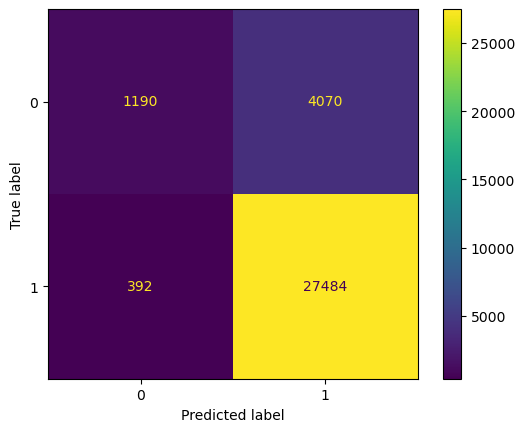

In [67]:
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

yhat = pd.Series(simple_model.predict(vstack(test_data['word_count_subset_vec'])))
                 
cm = confusion_matrix(y_pred=yhat, y_true=test_data['sentiment'])
print(cm)

ConfusionMatrixDisplay(cm).plot()

***Question 30.*** What fraction of the positive reviews in the **test set** were correctly predicted as positive by the classifier? 

In [76]:
# YOUR CODE HERE
print(cm[1][1] / (cm[1][0] + cm[1][1]))

0.9859377242072034


## Computing the cost of mistakes

A manufacturer that sells a baby product on Amazon.com will want to monitor their product's reviews in order to respond to complaints. Even a few negative reviews may generate a lot of bad publicity about the product. Therefore, they won't want to miss any negative sentiment reviews. It is far preferable to tolerate a few false alarms rather than miss negative reviews entirely. 

***Question 31.*** Under this assumption, which type of mistake (false positive or false negative) should be considered more costly?

We should consider false positives more costly.

***Question 32.*** Let's assign a cost of \$100 to each of the worse type of mistake, and a cost of 1 dollar to each of the lesser kind of mistake. Correctly classified reviews incur no cost. Under this assumption, what is the total cost on the test data incurred by using your model? (Note that this is the estimated loss incurred by *all* manufacturers of baby products.) Print your answer as a $ amount.

In [80]:
# YOUR CODE HERE
print(f'Total cost of the model is {(cm[0][1] * 100) + (cm[1][0] * 1)}')

Total cost of the model is 407392


## Precision and Recall
When costs of mistakes are not symmetric, two additional measures, defined in lecture, become relevant:
$$
\text{precision} = \frac{\text{# true positives}}{\text{# true positives} + \text{# false positives}}
\hspace{0.2in}\text{and}\hspace{0.2in}
\text{recall} = \frac{\text{# true positives}}{\text{# true positives} + \text{# false negatives}}
$$

***Question 33.*** Using Scikit-learn, evaluate, to three decimail places, the *precision* and *recall* of your model on the test data.

In [81]:
# YOUR CODE HERE
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_pred=yhat, y_true=test_data['sentiment'])
recall = recall_score(y_pred=yhat, y_true=test_data['sentiment'])


print(f'Precision: {round(precision, 3)}\nRecall: {round(recall, 3)}')


prediction = np.full((len(test_data['sentiment']), 1), majority_class[0])

precision_maximum = precision_score(y_pred=prediction , y_true=test_data['sentiment'])
print(f'Precision Maximum: {round(precision_maximum, 3)}')

recall_maximum = recall_score(y_pred=prediction, y_true=test_data['sentiment'])
print(f'Recall Maximum: {round(recall_maximum)}')

Precision: 0.871
Recall: 0.986
Precision Maximum: 0.841
Recall Maximum: 1


***Question 34.*** What is the recall value for a classifier that predicts **+1** for all data points in the **test_data**?

1

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to
optimize one of these two measures (which one depends on the types of error you are trying to avoid.)

***Question 35.*** Which of the measures above should be maximized keeping in mind the goal of not missing too many negative reviews? Let's say we want a rate greater than 95%. To what extent does your model achieve this. Explain, and then quantify your answer to determine if you have succeeded or not.

Precision, because we want to get false positives close to 0, and since the equation of precision is TP / (TP + FP), the only way to maximize this is by getting FP closer and closer to 0. 

In [82]:
# YOUR CODE HERE
print(f'Both models fall short of the 95% rate, where the precision of the simple_model is {round(precision, 3)} and the precision of the majority model is {round(precision_maximum, 3)}')

Both models fall short of the 95% rate, where the precision of the simple_model is 0.871 and the precision of the majority model is 0.841


***Question 36.*** Based on what we learned, if we wanted to reduce the number of missed negative reviews to below 3%, we should (select one only):

1. Discard a sufficient number of positive predictions
2. Discard a sufficient number of negative predictins
3. Increase threshold for predicting the positive class ($\hat{y} = +1$)
4. Decrease threshold for predicting the positive class ($\hat{y} = +1$)

**Answer**
3. Increase threshold for prediction the positive class

## Precision-recall tradeoff

We will now explore the trade-off between precision and recall discussed in class. We first examine what happens when we use a different threshold when making class predictions. We then explore a range of threshold values and plot the associated precision-recall curve.  

### Varying the threshold

Suppose want to be more conservative about making positive predictions (i.e., be more confident when making such a prediction). To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold. 

***Question 37.*** Write a function `apply_threshold` that accepts two arguments:
* `probabilities` (a NumPy array of probability values)
* `threshold` (a float between 0 and 1).

The function should return a NumPy array, where each element is set to +1 or -1 depending whether the corresponding probability exceeds `threshold` or not.

In [110]:
# YOUR CODE HERE
def apply_threshold(probabilities, threshold):
    return np.array([1 if i[1] > threshold else -1 for i in probabilities])

Run prediction with `.predict_proba` to get the list of probability values. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

***Question 38.*** What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9? Answer by providing the number of positive predictions in each case. Make sure to use your `apply_threshold` function.

In [111]:
# Number of positive decreases
# YOUR CODE HERE
probs = simple_model.predict_proba(vstack(test_data['word_count_subset_vec'].values))

pred_threshold_5 = apply_threshold(probs, 0.5)


pred_threshold_9 = apply_threshold(probs, 0.9)

pos_threshold_5 = sum(1 for i in pred_threshold_5 if i == 1)
pos_threshold_9 = sum(1 for i in pred_threshold_9 if i == 1)

print(f'Threshold 0.5: {pos_threshold_5}\nThreshold 0.9: {pos_threshold_9}')

Threshold 0.5: 31554
Threshold 0.9: 16189


### Exploring the associated precision and recall for different threshold values
By changing the threshold, it is possible to influence precision and recall. 

***Question 39.*** Compute the precision and recall with thresholds $\tau=0.5$ and $\tau=0.9$. Print with three decimal places of precision.

In [112]:
# YOUR CODE HERE
prec_thresh_5 = precision_score(y_true = test_data['sentiment'], y_pred = pred_threshold_5)
prec_thresh_9 = precision_score(y_true = test_data['sentiment'], y_pred = pred_threshold_9)

rec_thresh_5 = recall_score(y_true = test_data['sentiment'], y_pred = pred_threshold_5)
rec_thresh_9 = recall_score(y_true = test_data['sentiment'], y_pred = pred_threshold_9)

print(f'0.5 - Precision: {prec_thresh_5}; Recall: {rec_thresh_5}')
print(f'0.9 - Precision: {prec_thresh_9}; Recall: {rec_thresh_9}')

0.5 - Precision: 0.8710147683336502; Recall: 0.9859377242072034
0.9 - Precision: 0.9613935388226573; Recall: 0.55832974601808


***Question 40.*** Does the **precision** increase with a higher threshold?
Does the **recall** increase with a higher threshold? Explain.

Precision does increase, but the recall decreases with a higher threshold.

### Precision-recall curve

We will now explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve.

In [113]:
threshold_values = np.linspace(0.5, 1, num=100)

***Question 41.*** For each of the values of threshold, compute the precision and recall scores and store them in lists `precision_all` and `recall_all`, respectively.

In [114]:
# YOUR CODE HERE
precision_all = []
recall_all = []
for i in threshold_values:
    y_temp = apply_threshold(probs, i)
    precision_all.append(precision_score(y_pred = y_temp, y_true = test_data['sentiment']))
    recall_all.append(recall_score(y_pred = y_temp, y_true = test_data['sentiment']))
    

In [115]:
# Print the last entry of each list
print(f'{precision_all[-1]} {recall_all[-1]}')

0.0 0.0


***Question 42.*** Write a function `plot_pr_curve` that takes a list of precision values and a list of the corresponding recall values and plots the precision-recall curve for those values. Plot the precision-recall curve for the lists `precision_all` and `recall_all` computed above. Make sure to include informative labels for the axes and the plot as a whole.

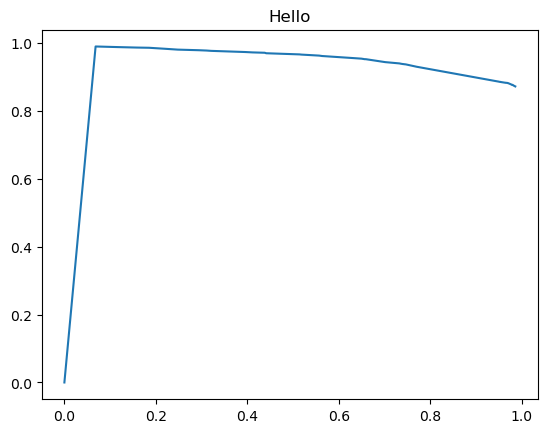

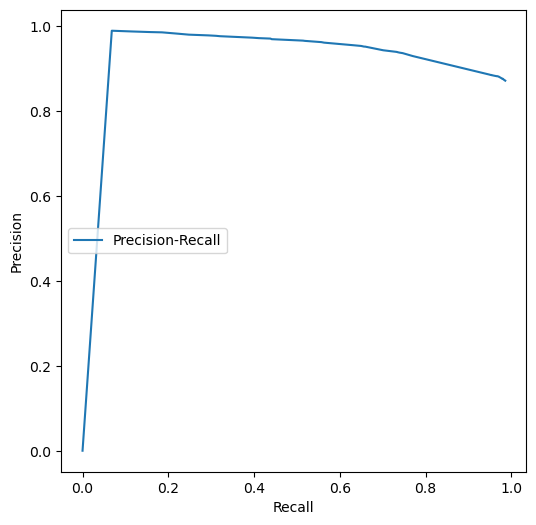

In [125]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.plot(recall, precision)
    plt.title(title)
    plt.show()
    
def plot_pr_curve_hec(prec, rec, title):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(rec, prec, label=title)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc='center left');
    
plot_pr_curve(precision_all, recall_all, 'Hello')

plot_pr_curve_hec(precision_all, recall_all, 'Precision-Recall')

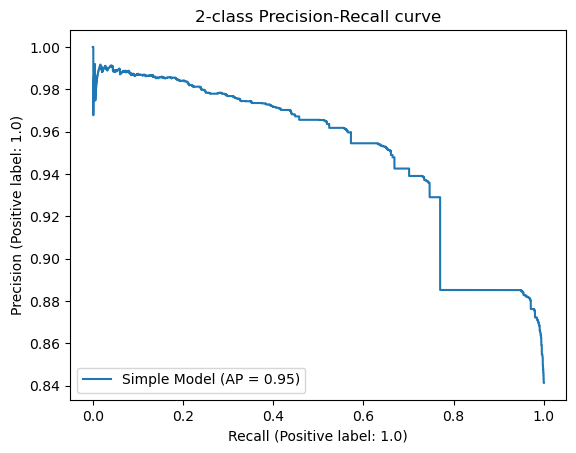

In [121]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    simple_model, vstack(test_data['word_count_subset_vec'].values), test_data['sentiment'], name="Simple Model"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

***Question 43.*** Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 97% or better? Round your answer to 3 decimal places.

In [133]:
# YOUR CODE HERE
zipped_thresh_prec = zip(precision_all, threshold_values)
print([round(i[1], 3) for i in zipped_thresh_prec if i[0] >= 0.97])

# The smallest threshold is 0.929

[0.929, 0.934, 0.939, 0.944, 0.949, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995]


***Question 44.*** Using `threshold` = 0.98, how many **false negatives** do we get on the **test_data**? This is the number of reviews you would read when not needed. (*Hint:* You can easily get this from the confusion matrix.)  

In [139]:
pred_98 = apply_threshold(probs, 0.98)

tn, fp, fn, tp = confusion_matrix(y_pred = pred_98, y_true=test_data['sentiment']).ravel()

print(f'False Neg: {fn}')

False Neg: 22724


## Evaluating specific products
So far, we have considered the **entire** set. In this section, let's select reviews using a specific search term and optimize our choice of precision/recall on these reviews only. After all, a manufacturer would be interested in tuning the model just for their products (the reviews they need to read) rather than that of the entire set of products on Amazon.

### Precision-Recall on all baby related items

From the **test set**, we select all the reviews for all products with the word 'baby' in them (In practice, you would provide a specific set of products, those of interest to the manufacturer. Here, we are simply illustrating how to do this.)

In [136]:
baby_reviews = test_data[test_data['name'].str.contains('baby', na=False)]

***Question 45.*** Predict the probability of classifying these reviews as positive.

In [141]:
# YOUR CODE HERE
baby_proba = simple_model.predict_proba(vstack(baby_reviews['word_count_subset_vec'].values))
baby_proba

array([[0.24301564, 0.75698436],
       [0.40651472, 0.59348528],
       [0.24301564, 0.75698436],
       ...,
       [0.12332736, 0.87667264],
       [0.01386255, 0.98613745],
       [0.01238971, 0.98761029]])

In [145]:
# YOUR CODE HERE
precision_all_baby = []
recall_all_baby = []
for i in threshold_values:
    y_temp = apply_threshold(baby_proba, i)
    precision_all_baby.append(precision_score(y_pred = y_temp, y_true = baby_reviews['sentiment']))
    recall_all_baby.append(recall_score(y_pred = y_temp, y_true = baby_reviews['sentiment']))
    

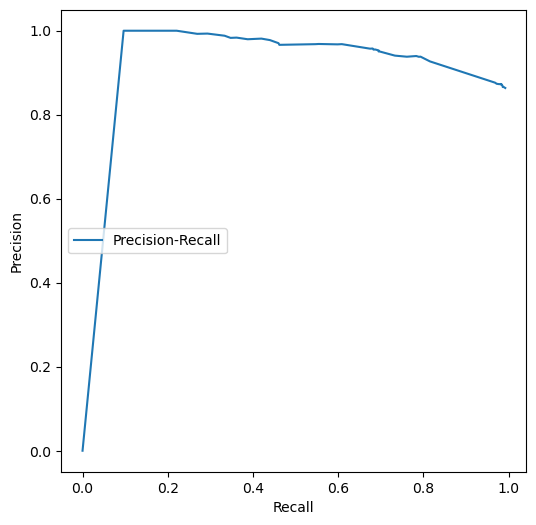

In [146]:
plot_pr_curve_hec(precision_all_baby, recall_all_baby, 'Precision-Recall')

Let's plot the precision-recall curve for the **baby_reviews** dataset.
We'll use the same `threshold_values` as above.

***Question 46.*** Compute precision and recall for each value in `threshold_values` on the **baby_reviews** dataset. Plot the precision-recall curve.

In [147]:
# YOUR CODE HERE
# DONE ABOVE, MY BAD BRO

***Question 47.*** Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 97% or better for the reviews of data in **baby_reviews**? Round your answer to 3 decimal places.

In [148]:
# YOUR CODE HERE
zipped_thresh_prec = zip(precision_all_baby, threshold_values)
print([round(i[1], 3) for i in zipped_thresh_prec if i[0] >= 0.97])

# The smallest threshold is 0.929

[0.929, 0.934, 0.939, 0.944, 0.949, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995]


***Question 48.*** Is this threshold value smaller or larger than the threshold used for the entire dataset to achieve the same specified precision of 97%?

ITS THE SAME NUMBER... WHAT?!?!?!?!?